In [1]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import cbpro
from pathlib import Path
import seaborn as sns
import requests
from creds import api_key

import tensorflow as tf
import tensorflow_probability as tfp
from pandasgui import show

tf.distribute.OneDeviceStrategy(device="/gpu:0")
# policy = tf.keras.mixed_precision.Policy("mixed_float16")
# tf.keras.mixed_precision.experimental.set_policy(policy)

public_client = cbpro.PublicClient()

In [2]:
class MinerMeta(type):
    # def __init__(self):
    #     result = getattr(self, "df", None)
    #     if result is None:
    #         self.df = self.compile_historic(read_csv=True)

    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]

            # timestamp_s = date_time.map(pd.Timestamp.timestamp)
            # day = 24 * 60 * 60
            # year = (365.2425) * day
            # df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            # df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            # df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            # df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False, inplace=True)

            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()
        ylim = int(df[col].max())
        plt.figure(figsize=(15, 10))

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        hours_per_week = 24 * 7
        years_per_dataset = n_samples_h / (hours_per_year)
        hours_per_dataset = n_samples_h / (hours_per_week)

        f_per_year = f_per_dataset / years_per_dataset
        f_per_week = f_per_dataset / hours_per_dataset
        plt.step(f_per_week, np.abs(fft))
        plt.xscale("log")
        # plt.ylim(1000, ylim)
        # plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7], labels=["1/Week", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        # setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


In [3]:
# # api_key = r"ru1zaf0ssaa29394mb4ahp"
# lc_file = Path.cwd() / "lc_data.csv"
# coins = "ETH"


# def lc_data(read_csv=False):
#     file = Path.cwd() / "lunardata.csv"
#     if read_csv is True:
#         data = pd.read_csv(file, index_col="id")
#         return data
#     else:
#         assets_url = (
#             b"https://api.lunarcrush.com/v2?data=assets&key="
#             + api_key
#             + "&symbol="
#             + coins
#             + +"&data_points=720"
#         )
#         assets = json.loads(urllib.request.urlopen(assets_url).read())
#         # config = pd.DataFrame.from_dict(assets["config"], orient="index")
#         # usage = pd.DataFrame.from_dict(assets["usage"], orient="index")
#         data = pd.DataFrame.from_dict(assets["data"])
#         return data


# lc = lc_data()

# lc.tail()


In [4]:
# lc_file = Path.cwd() / "lc_data.csv"
# coins = "ETH"
# intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
# now = datetime.now()
# delta = timedelta(30)
# start = now - delta

# payload = {
#     "key": api_key,
#     "symbol": coins,
#     "change": intervals,
#     "data_points": "720",
#     # "start": datetime.timestamp(start),
#     # "end": datetime.timestamp(start + timedelta(30)),
# }

# r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

# data = pd.DataFrame.from_dict(r.json()["data"][0])

# ts = data.timeSeries.to_dict()
# new = pd.DataFrame.from_dict(ts, orient="index")
# new.pop("asset_id")
# new["time"] = pd.to_datetime(new["time"], unit="s")
# new.set_index("time", inplace=True)
# new.sort_index(ascending=False)
# print("Min", new.index.min())
# print("Max", new.index.max())
# print(new.index.max() - new.index.min())
# print(list(new.columns))
# new.tail()


In [5]:
def compile_lc_data(coins="ETH"):
    intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
    now = datetime.now()
    # delta = timedelta(num_days_in_past)
    # ut = datetime.timestamp((now - delta))

    payload = {
        "key": api_key,
        "symbol": coins,
        "change": intervals,
        "data_points": "720",
        # "start": ut,
        # "end": datetime.timestamp(now),
    }

    r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

    data = pd.DataFrame.from_dict(r.json()["data"][0])
    ts = data.timeSeries.to_dict()
    new = pd.DataFrame.from_dict(ts, orient="index")
    new.pop("asset_id")
    new["time"] = pd.to_datetime(new["time"], unit="s")
    new.set_index("time", inplace=True)
    new.sort_index(ascending=False, inplace=True)
    new["month"] = [new.index[i].month for i in range(len(new))]
    new["day"] = [new.index[i].day for i in range(len(new))]
    new["hour"] = [new.index[i].hour for i in range(len(new))]

    return new


df = compile_lc_data()
df.tail()

,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,month,day,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-09-23 08:00:00,3147.995019,3121.067164,3148.121710,3117.828470,1.191794e+09,367281759944,680,401,25.0,38.0,...,3077,0.071047,45553,6.754769,2.291349e+12,16.029062,6.477777,9,23,8
2021-09-23 07:00:00,3136.703821,3148.032373,3148.525207,3116.939074,1.384814e+09,370224761946,773,383,39.0,230.0,...,2887,0.071058,43320,6.664358,2.312022e+12,16.013029,6.800722,9,23,7
2021-09-23 06:00:00,3115.632693,3136.393215,3138.903194,3101.972101,1.243554e+09,368771717328,802,362,29.0,184.0,...,2856,0.070670,39637,7.205389,2.310629e+12,15.959799,6.876997,9,23,6
2021-09-23 05:00:00,3116.757622,3116.746948,3136.413810,3108.735574,1.155335e+09,366371281957,882,325,23.0,207.0,...,2820,0.071025,37360,7.548180,2.287462e+12,16.016497,8.304055,9,23,5
2021-09-23 04:00:00,3122.127410,3116.746279,3136.153754,3106.544144,1.383064e+09,366697218684,1256,266,22.0,1009.0,...,2408,0.070619,41022,5.870021,2.287271e+12,16.032087,9.442713,9,23,4


In [6]:
def ttsplit_norm(df, split_time=0.7, feature_plot=False):
    # Fill NaN with column mean
    df = df.fillna(df.mean())
    # train_df Test Split
    n = len(df)
    train_df = df[0 : int(n * split_time)]
    val_df = df[int(n * split_time) : int(n * 0.9)]
    test_df = df[int(n * 0.9) :]

    # Normalize the Data
    train_df_mean = train_df.mean()
    train_df_std = train_df.std()

    train_df = (train_df - train_df_mean) / train_df_std
    val_df = (val_df - train_df_mean) / train_df_std
    test_df = (test_df - train_df_mean) / train_df_std

    # Create Feature Plot if wanted
    if feature_plot is True:
        df_std = (df - train_df_mean) / train_df_std
        df_std = df_std.melt(var_name="Column", value_name="Normalized")
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
        ax.set_xticklabels(df.keys(), rotation=90)
        ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

        return train_df, val_df, test_df

    return train_df, val_df, test_df


train, val, test = ttsplit_norm(df, feature_plot=False)

print(len(train))
print(len(val))
print(len(test))


504
144
73


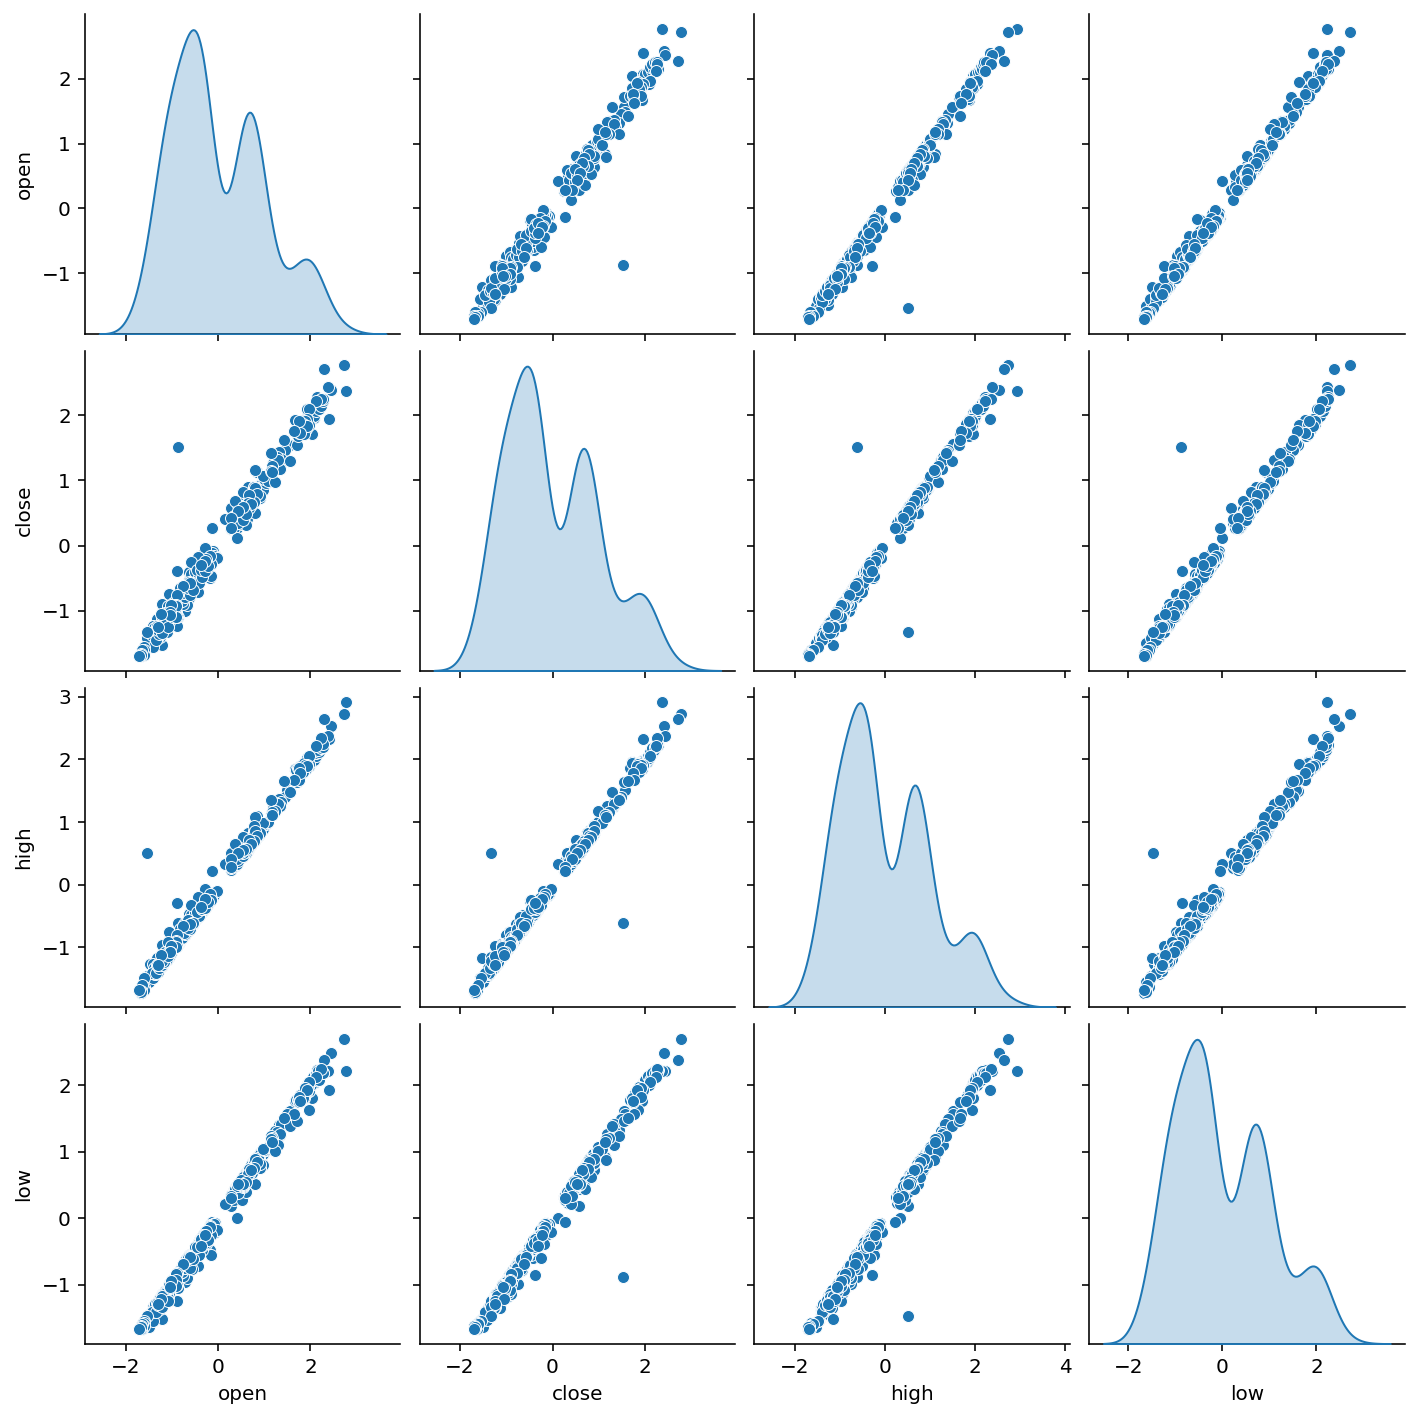

In [7]:
cols = df.columns
cols = cols[:4]
sns.pairplot(train[cols], diag_kind="kde")


In [25]:
WINDOW_SIZE = 60
BATCH_SIZE = 128
SHUFFLE_BUFFER = 1000


def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    """
    Utility function for time series data generation in batches
    """
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    ts_data = ts_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ts_data

In [26]:
train_index = np.array(train.index).astype("float32")
train_data = np.array(train.values).astype("float32")
val_index = np.array(val.index).astype("float32")
val_data = np.array(val.index).astype("float32")
test_index = np.array(test.index).astype("float32")
test_data = np.array(test.index).astype("float32")

train_ds = ts_data_generator(train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
val_ds = ts_data_generator(val_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_ds = ts_data_generator(test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

print(train_ds.take(1))


<TakeDataset shapes: ((None, None, 60), (None, 60)), types: (tf.float32, tf.float32)>


In [27]:
# train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
#     trainx, trainy, sequence_length=168
# )

# test_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
#     testx, testy, sequence_length=168
# )


In [28]:
model = tf.keras.models.Sequential(
    [
        # tf.keras.layers.Dense(20, activation="relu"),
        # tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])
model.fit(train_ds, epochs=20, validation_data=val_ds)


Epoch 1/20
      1/Unknown - 1s 549ms/step - loss: nan - mse: nanWARNING:tensorflow:Model was constructed with shape (None, None, 60) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, 60), dtype=tf.float32, name='dense_3_input'), name='dense_3_input', description="created by layer 'dense_3_input'"), but it was called on an input with incompatible shape (None, None).
4/4 [==============================] - 1s 78ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/20
4/4 [==============================] - 0s 29ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/20
4/4 [==============================] - 0s 27ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/20
4/4 [==============================] - 0s 30ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/20
4/4 [=============================

In [ ]:
CONV_WIDTH = 3
multi_val_performance = {}
multi_performance = {}

dev_model = tf.keras.models.Sequential(
    [
        # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(CONV_WIDTH),
            strides=1,
            padding="causal",
            # activation="relu",
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=False)
        ),
        # tf.keras.layers.Bidirectional(
        #     tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(128),
        # tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(1),
    ]
)

dev_model.compile(
    loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
)
dev_model.fit(train_ds, epochs=20)
